In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import re

from collections import Counter, defaultdict
from pyfaidx import Fasta
from tqdm.notebook import tqdm

# Finding possible interactors of LIN28A which might cause peri-ER localization

The original article suggested strong evidences such that:
- Integral membrane protein coding mRNAs are highly enriched by LIN28A (and also, their translation highly downregulated)
- Specifically, cotranslationally ER translocated mRNAs are highly enriched by LIN28A
- LIN28A is localized to peri-ER area

But since motif score analysis done by HMM didn't show differences between ER-associated mRNAs and non-ER-associated mRNAs, we still don't know why LIN28A is localized to peri-ER area. So I will start from following hypotheses:
1. LIN28A interacts with ER surface protein/lipid
2. LIN28A interacts with RBP or adapter protein s.t. cotranslationally bounds to ER-associated mRNA.
3. LIN28A directly recognizes ER-associated mRNA sequence/structure/modification context.

Performed some pilot research, but found no evidences supporting hypothesis 1 and 2. Using other CLIP-seq or Ribosome profiling (a.k.a. Ribosome footprinting) data to find other novel recognition site of LIN28A would be better.

In [ ]:
# So let's start from here...

# New research plan: calculating codon occupancy with ribosome profiling data

1. Get P-site offset w.r.t read length
2. Calculate P-site occupancy over exons
3. Calculate and nomalize codon occupancy

In [ ]:
# Manually extract exons with start codon
!grep $'\tstart_codon\t.*\t[+-]\t.*transcript_support_level "1"' ../binfo1-datapack1/gencode.gtf | \
    sed -e 's/	[^	]*transcript_id "\([^"]*\)".*$/	\1/g' > gencode-start.gtf

In [ ]:
!grep $'\texon\t.*\t[+-]\t.*transcript_support_level "1"' ../binfo1-datapack1/gencode.gtf | \
    sed -e 's/	[^	]*transcript_id "\([^"]*\)".*$/	\1/g' > gencode-exon.gtf

In [ ]:
# Convert coordinates to 0-based, half-open
!bedtools intersect -a gencode-start.gtf -b gencode-exon.gtf -wa -wb | \
 awk -F'	' -v OFS='	' '$9 == $18 { print $10, $13-1, $14, $18, $4-1, $16; }' | \
 sort -k1,1 -k2,3n -k4,4 > gencode-exons-containing-startcodon.bed
!head gencode-exons-containing-startcodon.bed; tail gencode-exons-containing-startcodon.bed

In [ ]:
# Now remove duplicates by selecting principal transcripts
%cd ../binfo1-datapack1
!stringtie RNA-siLuc.bam -G gencode.gtf -o stringtie-RNA-siLuc.gtf -p 10
!awk -F'\t' '$3 == "transcript"' stringtie-RNA-siLuc.gtf > stringtie-RNA-siLuc-transcript.gtf

In [ ]:
!mv stringtie-RNA-siLuc-transcript.gtf ../binfo1-own-analysis/
%cd ../binfo1-own-analysis

In [40]:
# You can resume from here
# 1-based, closed coordinates
df = pd.read_csv('stringtie-RNA-siLuc-transcript.gtf', sep='\t', header=None)
df.columns = ['chromosome', 'program', 'type', 'start', 'end', 'unnamed1', 'strand', 'unnamed2', 'info']

In [ ]:
df['TPM'] = df['info'].str.extract(r'TPM "([^"]+)"').astype(float)
df['transcript_id'] = df['info'].str.extract(r'reference_id "([^"]+)"')
df.head()

,chromosome,program,type,start,end,unnamed1,strand,unnamed2,info,TPM,transcript_id
0,chr1,StringTie,transcript,3822233,3824583,1000,+,.,"gene_id ""STRG.1""; transcript_id ""STRG.1.1""; re...",0.035499,ENSMUST00000194454.2
1,chr1,StringTie,transcript,4599240,4599346,1000,+,.,"gene_id ""STRG.2""; transcript_id ""STRG.2.1""; re...",0.164673,ENSMUST00000240255.1
2,chr1,StringTie,transcript,4680694,4681629,1000,+,.,"gene_id ""STRG.3""; transcript_id ""STRG.3.1""; re...",1.015851,ENSMUST00000192738.2
3,chr1,StringTie,transcript,4758157,4759626,1000,-,.,"gene_id ""STRG.4""; transcript_id ""STRG.4.1""; re...",6.622187,ENSMUST00000182774.2
4,chr1,StringTie,transcript,4762442,4763647,1000,-,.,"gene_id ""STRG.5""; transcript_id ""STRG.5.1""; re...",0.312567,ENSMUST00000193443.2


In [ ]:
# 0-based, half-open coordinates
bed = pd.read_csv('gencode-exons-containing-startcodon.bed', sep='\t', header=None)
bed.columns = ['chromosome', 'start', 'end', 'transcript_id', 'start_codon', 'strand']
bed.head()

,chromosome,start,end,transcript_id,start_codon,strand
0,chr1,3740775,3741721,ENSMUST00000070533.5,3741569,-
1,chr1,4422425,4423060,ENSMUST00000027032.6,4423046,-
2,chr1,4563323,4563689,ENSMUST00000027035.10,4563627,-
3,chr1,4563323,4563713,ENSMUST00000116652.8,4563627,-
4,chr1,4563323,4563958,ENSMUST00000191939.2,4563627,-


In [43]:
merged_df = pd.merge(bed, df, on='transcript_id', how='left')
merged_df['TPM'] = merged_df['TPM'].fillna(0)
idx = merged_df.groupby(['chromosome_x', 'strand_x', 'start_codon'])['TPM'].idxmax()
principal_exons_df = merged_df.loc[idx]
principal_exons_df.head()

,chromosome_x,start_x,end_x,transcript_id,start_codon,strand_x,chromosome_y,program,type,start_y,end_y,unnamed1,strand_y,unnamed2,info,TPM
11,chr1,4878046,4878205,ENSMUST00000027036.11,4878137,+,chr1,StringTie,transcript,4878046.0,4916962.0,1000.0,+,.,"gene_id ""STRG.28""; transcript_id ""STRG.28.1""; ...",58.482693
13,chr1,4928037,4928199,ENSMUST00000081551.14,4928137,+,chr1,StringTie,transcript,4928037.0,4968128.0,1000.0,+,.,"gene_id ""STRG.29""; transcript_id ""STRG.29.1""; ...",128.363068
15,chr1,5154640,5154786,ENSMUST00000044369.13,5154674,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
16,chr1,5659228,5659528,ENSMUST00000027038.11,5659272,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
18,chr1,6300183,6300297,ENSMUST00000027040.13,6300227,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [ ]:
bedout = principal_exons_df[['chromosome_x', 'start_x', 'end_x', 'transcript_id', 'start_codon', 'strand_x']]
bedout.columns = ['chromosome', 'start', 'end', 'transcript_id', 'start_codon', 'strand']
bedout.to_csv('gencode-principal-exons-containing-startcodon.bed', sep='\t', header=False, index=False)
# 0-based, half-open coordinates

In [ ]:
# Generate new bam file with only mapped reads
!(samtools view -H ../binfo1-datapack1/RPF-siLuc.bam; samtools view -F 4 ../binfo1-datapack1/RPF-siLuc.bam | bioawk -c sam '{ if (length($seq) >= 25) print $0; }') | samtools view -b -o  RPF-siLuc-filtered.bam
!(samtools view -H ../binfo1-datapack1/RPF-siLin28a.bam; samtools view -F 4 ../binfo1-datapack1/RPF-siLin28a.bam | bioawk -c sam '{ if (length($seq) >= 25) print $0; }') | samtools view -b -o  RPF-siLin28a-filtered.bam
!samtools index RPF-siLuc-filtered.bam
!samtools index RPF-siLin28a-filtered.bam

In [ ]:
# # Get 5' ends of +/- strand reads
# !bedtools genomecov -ibam RPF-siLuc-filtered.bam -bg -5 -strand + > fivepcnt-RPF-siLuc.plus.bed
# !bedtools genomecov -ibam RPF-siLuc-filtered.bam -bg -5 -strand - > fivepcnt-RPF-siLuc.minus.bed

In [ ]:
# !bedtools genomecov -ibam RPF-siLin28a-filtered.bam -bg -5 -strand + > fivepcnt-RPF-siLin28a.plus.bed
# !bedtools genomecov -ibam RPF-siLin28a-filtered.bam -bg -5 -strand - > fivepcnt-RPF-siLin28a.minus.bed

In [ ]:
# !bedtools intersect -a fivepcnt-RPF-siLuc.plus.bed -b gencode-principal-exons-containing-startcodon.bed -wa -wb -nonamecheck > fivepcnt-RPF-siLuc.plus.txt
# !bedtools intersect -a fivepcnt-RPF-siLuc.minus.bed -b gencode-principal-exons-containing-startcodon.bed -wa -wb -nonamecheck > fivepcnt-RPF-siLuc.minus.txt

In [ ]:
# !bedtools intersect -a fivepcnt-RPF-siLin28a.plus.bed -b gencode-principal-exons-containing-startcodon.bed -wa -wb -nonamecheck > fivepcnt-RPF-siLin28a.plus.txt
# !bedtools intersect -a fivepcnt-RPF-siLin28a.minus.bed -b gencode-principal-exons-containing-startcodon.bed -wa -wb -nonamecheck > fivepcnt-RPF-siLin28a.minus.txt

In [ ]:
siluc = pysam.AlignmentFile('RPF-siLuc-filtered.bam', 'rb')
silin28a = pysam.AlignmentFile('RPF-siLin28a-filtered.bam', 'rb')

In [ ]:
siluc_len = Counter(read.query_length for read in siluc.fetch(until_eof=True))
silin28a_len = Counter(read.query_length for read in silin28a.fetch(until_eof=True))
siluc_len_df = pd.DataFrame(siluc_len.items(), columns=['length', 'count'])
silin28a_len_df = pd.DataFrame(silin28a_len.items(), columns=['length', 'count'])
siluc_len_df['proportion'] = siluc_len_df['count'] / siluc_len_df['count'].sum()
silin28a_len_df['proportion'] = silin28a_len_df['count'] / silin28a_len_df['count'].sum()
siluc_len_df['sample'] = 'siLuc'
silin28a_len_df['sample'] = 'siLin28a'
length_df = pd.concat([siluc_len_df, silin28a_len_df], ignore_index=True)
length_df.sort_values(by=['sample', 'length'], inplace=True)
length_df.to_csv('RPF_read_lengths.csv', index=False)

In [ ]:
# Preprocessing ends. Length distribution is saved in RPF_read_lengths.csv
length_df = pd.read_csv('RPF_read_lengths.csv')

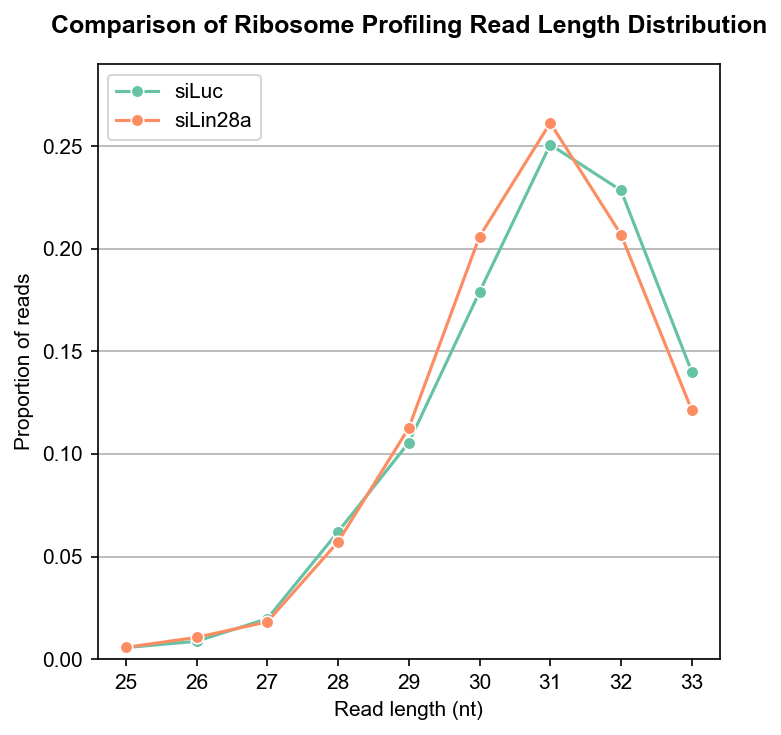

In [114]:
plt.figure(figsize=(5, 5), dpi=150)
# sns.set_style("whitegrid")
sns.lineplot(data=length_df, x='length', y='proportion', hue='sample', marker='o', palette='Set2', hue_order=['siLuc', 'siLin28a'])
plt.xlabel('Read length (nt)', fontsize=10)
plt.ylabel('Proportion of reads', fontsize=10)
plt.title('Comparison of Ribosome Profiling Read Length Distribution', fontsize=12, fontweight='bold', pad=15)
plt.ylim(0, 0.29)
plt.tight_layout()
plt.legend()
plt.grid(axis='y')
plt.show()

In [ ]:
# First, let's check the coordinate system

siluc_5p_plus = dict()
siluc_5p_minus = dict()

window = 30

for line in open('gencode-principal-exons-containing-startcodon.bed'):
    if line.startswith('#'):
        continue
    chrom, start, end, transcript_id, start_codon, strand = line.strip().split('\t')
    start_codon = int(start_codon)
    if strand == '-':
        start_codon += 2 # Points to the first base of 5' end

    for read in siluc.fetch(chrom, start_codon - window, start_codon + window):
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
        if read.is_reverse != (strand == '-'):
            continue
        # pysam uses 0-based, half-open coordinates
        read_5_end = read.reference_start if strand == '+' else read.reference_end - 1
        distance = read_5_end - start_codon if strand == '+' else start_codon - read_5_end

        if distance < -window or distance >= 0:
            continue
        if strand == '+':
            if read.query_length not in siluc_5p_plus:
                siluc_5p_plus[read.query_length] = Counter()
            siluc_5p_plus[read.query_length][distance] += 1
        else:
            if read.query_length not in siluc_5p_minus:
                siluc_5p_minus[read.query_length] = Counter()
            siluc_5p_minus[read.query_length][distance] += 1

siluc_5p_plus_df = pd.DataFrame.from_dict(siluc_5p_plus, orient='index').fillna(0).astype(int)
siluc_5p_plus_df.sort_index(axis=1, inplace=True)
siluc_5p_plus_df.sort_index(axis=0, inplace=True)
siluc_5p_plus_df = siluc_5p_plus_df.loc[:, -window:0]  # Keep only distances from -30 to 0
siluc_5p_plus_df.index = siluc_5p_plus_df.index.astype(int)

siluc_5p_minus_df = pd.DataFrame.from_dict(siluc_5p_minus, orient='index').fillna(0).astype(int)
siluc_5p_minus_df.sort_index(axis=1, inplace=True)
siluc_5p_minus_df.sort_index(axis=0, inplace=True)
siluc_5p_minus_df = siluc_5p_minus_df.loc[:, -window:0]  # Keep only distances from -30 to 0
siluc_5p_minus_df.index = siluc_5p_minus_df.index.astype(int)

In [66]:
siluc_5p_plus_df = siluc_5p_plus_df.apply(lambda x: x / x.sum(), axis=1)  # Normalize each row to sum to 1
siluc_5p_minus_df = siluc_5p_minus_df.apply(lambda x: x / x.sum(), axis=1)  # Normalize each row to sum to 1

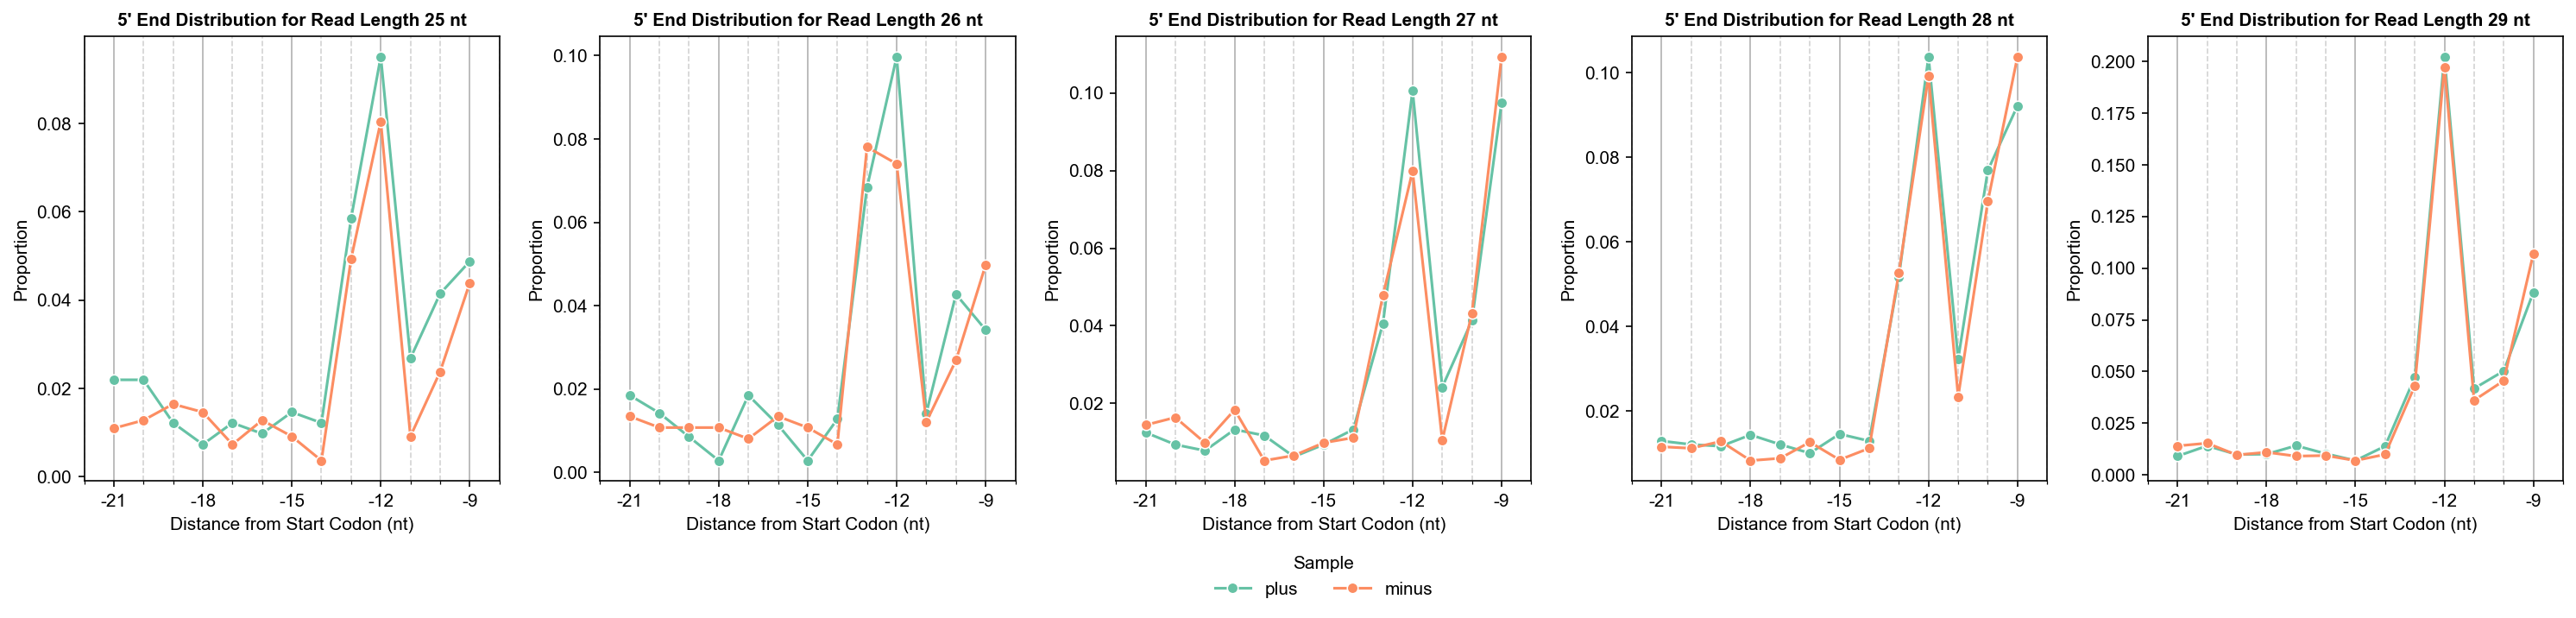

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(4 * 5, 5), dpi=150)
for i, length in enumerate(np.arange(25, 30)):
    row = siluc_5p_plus_df.loc[length][list(np.arange(-21, -8))]
    sns.lineplot(x=row.index, y=row.values, ax=ax[i], marker='o', color='#66c2a5', label='plus' if i == 2 else None)
    row = siluc_5p_minus_df.loc[length][list(np.arange(-21, -8))]
    sns.lineplot(x=row.index, y=row.values, ax=ax[i], marker='o', color='#fc8d62', label='minus' if i == 2 else None)

    ax[i].set_title(f'5\' End Distribution for Read Length {length} nt', fontsize=10, fontweight='bold')
    ax[i].set_xlabel('Distance from Start Codon (nt)', fontsize=10)
    ax[i].set_ylabel('Proportion', fontsize=10)
    ax[i].get_xaxis().set_major_locator(plt.MultipleLocator(3))
    ax[i].get_xaxis().set_minor_locator(plt.MultipleLocator(1))
    ax[i].grid(axis='x')
    ax[i].grid(axis='x', which='minor', color='lightgray', linestyle='--')
    ax[i].set_xlim(-22, -8)
    if i == 2:
        ax[i].legend(title='Sample', loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False)

plt.tight_layout()
plt.show()

In [68]:
# Now merge the two strands for siLuc

siluc_5p = dict()

window = 30

for line in open('gencode-principal-exons-containing-startcodon.bed'):
    if line.startswith('#'):
        continue
    chrom, start, end, transcript_id, start_codon, strand = line.strip().split('\t')
    start_codon = int(start_codon)
    if strand == '-':
        start_codon += 2

    for read in siluc.fetch(chrom, start_codon - window, start_codon + window):
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
        if read.is_reverse != (strand == '-'):
            continue

        read_5_end = read.reference_start if strand == '+' else read.reference_end - 1
        distance = read_5_end - start_codon if strand == '+' else start_codon - read_5_end

        if distance < -window or distance >= 0:
            continue

        if read.query_length not in siluc_5p:
            siluc_5p[read.query_length] = Counter()
        siluc_5p[read.query_length][distance] += 1

siluc_5p_df = pd.DataFrame.from_dict(siluc_5p, orient='index').fillna(0).astype(int)
siluc_5p_df.sort_index(axis=1, inplace=True)
siluc_5p_df.sort_index(axis=0, inplace=True)
siluc_5p_df = siluc_5p_df.loc[:, -window:0]  # Keep only distances from -30 to 0
siluc_5p_df.index = siluc_5p_df.index.astype(int)
siluc_5p_df.head()

,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,...,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1
25,9,6,9,10,13,11,8,2,12,15,...,30,44,24,84,98,53,98,63,34,105
26,24,22,13,17,27,6,3,13,25,23,...,50,61,107,140,116,66,108,93,63,115
27,31,29,26,37,18,16,25,32,29,38,...,119,292,204,215,244,112,169,204,133,204
28,102,137,136,64,47,104,118,115,111,127,...,756,1018,469,631,856,284,765,693,335,779
29,327,352,134,91,296,245,293,372,333,317,...,1290,2655,732,1002,2336,593,1260,2965,569,1158


In [69]:
siluc_5p_df = siluc_5p_df.apply(lambda x: x / x.sum(), axis=1)  # Normalize each row to sum to 1
siluc_5p_df.head()

,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,...,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1
25,0.009404,0.006270,0.009404,0.010449,0.013584,0.011494,0.008359,0.002090,0.012539,0.015674,...,0.031348,0.045977,0.025078,0.087774,0.102403,0.055381,0.102403,0.065831,0.035528,0.109718
26,0.016609,0.015225,0.008997,0.011765,0.018685,0.004152,0.002076,0.008997,0.017301,0.015917,...,0.034602,0.042215,0.074048,0.096886,0.080277,0.045675,0.074740,0.064360,0.043599,0.079585
27,0.011036,0.010324,0.009256,0.013172,0.006408,0.005696,0.008900,0.011392,0.010324,0.013528,...,0.042364,0.103952,0.072624,0.076540,0.086864,0.039872,0.060164,0.072624,0.047348,0.072624
28,0.009847,0.013226,0.013130,0.006179,0.004538,0.010041,0.011392,0.011103,0.010716,0.012261,...,0.072987,0.098282,0.045279,0.060919,0.082641,0.027418,0.073856,0.066905,0.032342,0.075208
29,0.012110,0.013036,0.004963,0.003370,0.010962,0.009073,0.010851,0.013777,0.012332,0.011740,...,0.047774,0.098326,0.027109,0.037108,0.086512,0.021961,0.046663,0.109807,0.021073,0.042886


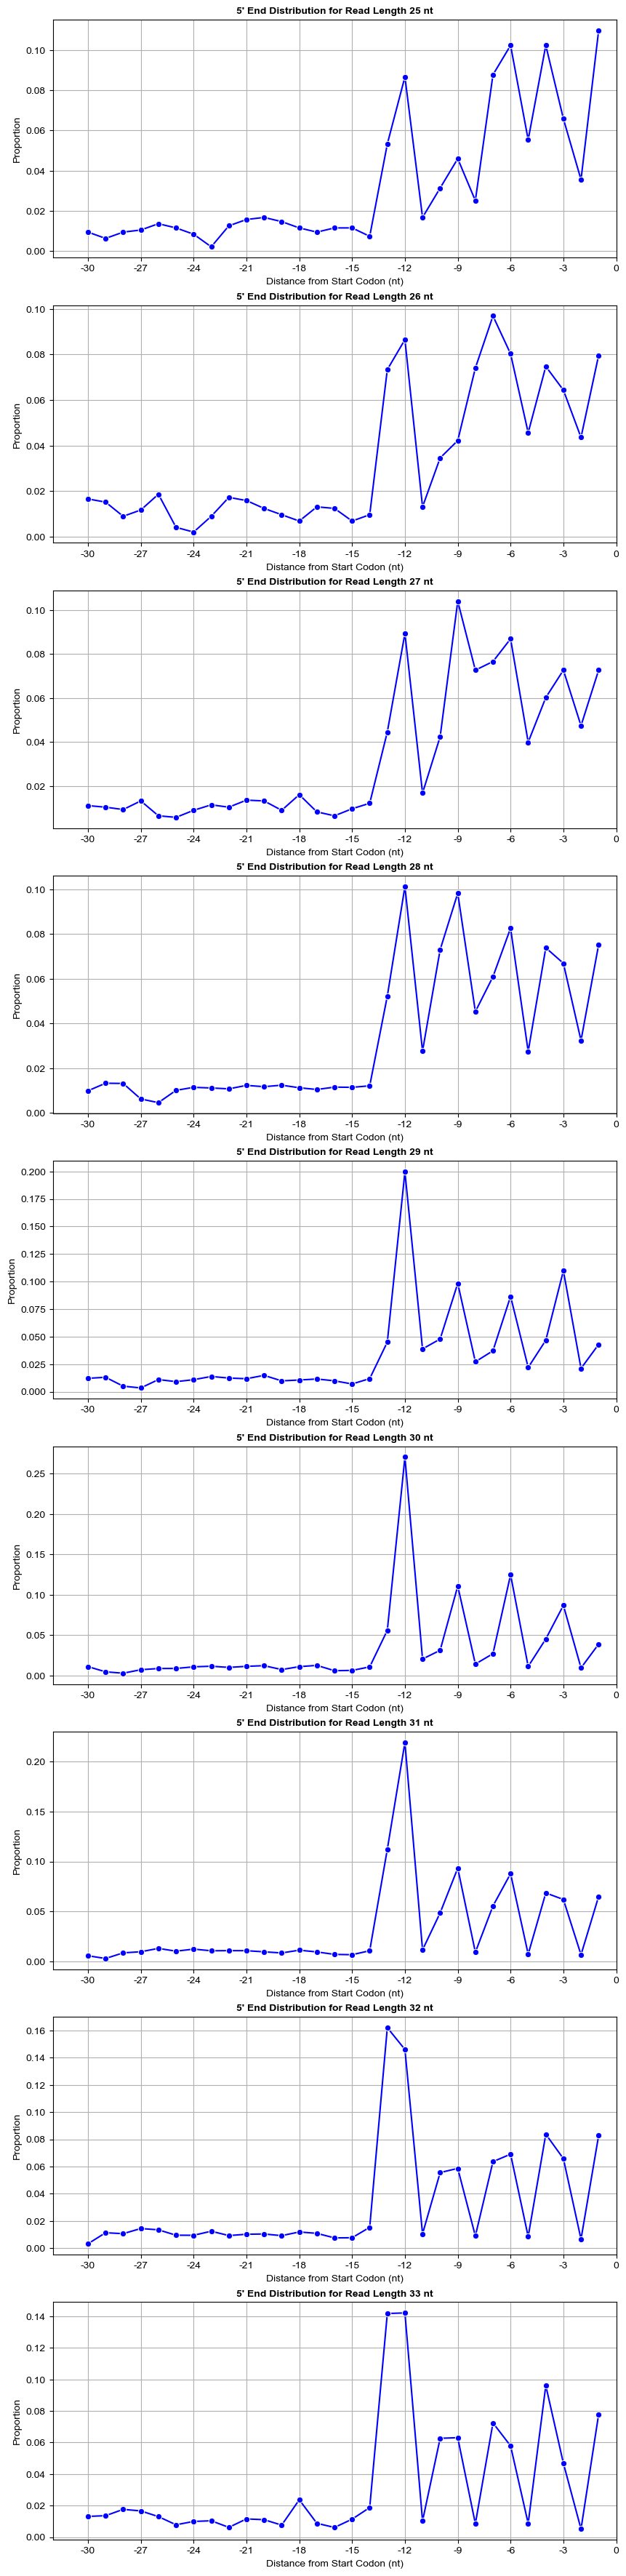

In [70]:
temp = siluc_5p_df.loc[25:33, -window:0].copy()
fig, ax = plt.subplots(nrows=temp.shape[0], ncols=1, figsize=(10, 5 * temp.shape[0]))
for i, (length, row) in enumerate(temp.iterrows()):
    sns.lineplot(x=row.index, y=row.values, ax=ax[i], marker='o', color='blue')
    ax[i].set_title(f'5\' End Distribution for Read Length {length} nt', fontsize=10, fontweight='bold')
    ax[i].set_xlabel('Distance from Start Codon (nt)', fontsize=10)
    ax[i].set_ylabel('Proportion', fontsize=10)
    ax[i].grid(True)
    ax[i].get_xaxis().set_major_locator(plt.MultipleLocator(3))
    ax[i].set_xlim(-window-2, 0)

In [71]:
# Now merge with siLin28a

silin28a_5p = dict()

window = 30

for line in open('gencode-principal-exons-containing-startcodon.bed'):
    if line.startswith('#'):
        continue
    chrom, start, end, transcript_id, start_codon, strand = line.strip().split('\t')
    start_codon = int(start_codon)
    if strand == '-':
        start_codon += 2

    for read in silin28a.fetch(chrom, start_codon - window, start_codon + window):
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
        if read.is_reverse != (strand == '-'):
            continue
        read_5_end = read.reference_start if strand == '+' else read.reference_end - 1
        distance = read_5_end - start_codon if strand == '+' else start_codon - read_5_end

        if distance < -window or distance >= 0:
            continue

        if read.query_length not in silin28a_5p:
            silin28a_5p[read.query_length] = Counter()
        silin28a_5p[read.query_length][distance] += 1

silin28a_5p_df = pd.DataFrame.from_dict(silin28a_5p, orient='index').fillna(0).astype(int)
silin28a_5p_df.sort_index(axis=1, inplace=True)
silin28a_5p_df.sort_index(axis=0, inplace=True)
silin28a_5p_df = silin28a_5p_df.loc[:, -window:window]  # Keep only distances from -30 to 0
silin28a_5p_df.index = silin28a_5p_df.index.astype(int)
silin28a_5p_df = silin28a_5p_df.apply(lambda x: x / x.sum(), axis=1)  # Normalize each row to sum to 1
silin28a_5p_df.head()

,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,...,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1
25,0.001285,0.008997,0.003856,0.007712,0.003856,0.017995,0.003856,0.002571,0.007712,0.011568,...,0.025707,0.052699,0.035990,0.120823,0.107969,0.095116,0.104113,0.068123,0.032134,0.073265
26,0.009223,0.004611,0.005929,0.009881,0.008564,0.007905,0.001976,0.009223,0.010540,0.013175,...,0.032279,0.065217,0.074440,0.113307,0.093544,0.042161,0.068511,0.060606,0.051383,0.055336
27,0.006930,0.006523,0.011822,0.008969,0.005300,0.004484,0.005707,0.011822,0.007746,0.008969,...,0.046881,0.119038,0.081940,0.064819,0.087240,0.034244,0.050958,0.073380,0.032613,0.059111
28,0.007539,0.010406,0.010512,0.005097,0.005521,0.006795,0.007963,0.010193,0.007645,0.008070,...,0.086324,0.118072,0.043003,0.051391,0.093332,0.021130,0.058930,0.059461,0.021342,0.049904
29,0.008590,0.010187,0.003768,0.003257,0.007089,0.007600,0.009133,0.011049,0.009389,0.009133,...,0.040557,0.105193,0.021843,0.026410,0.086766,0.018043,0.031551,0.105480,0.013955,0.027528


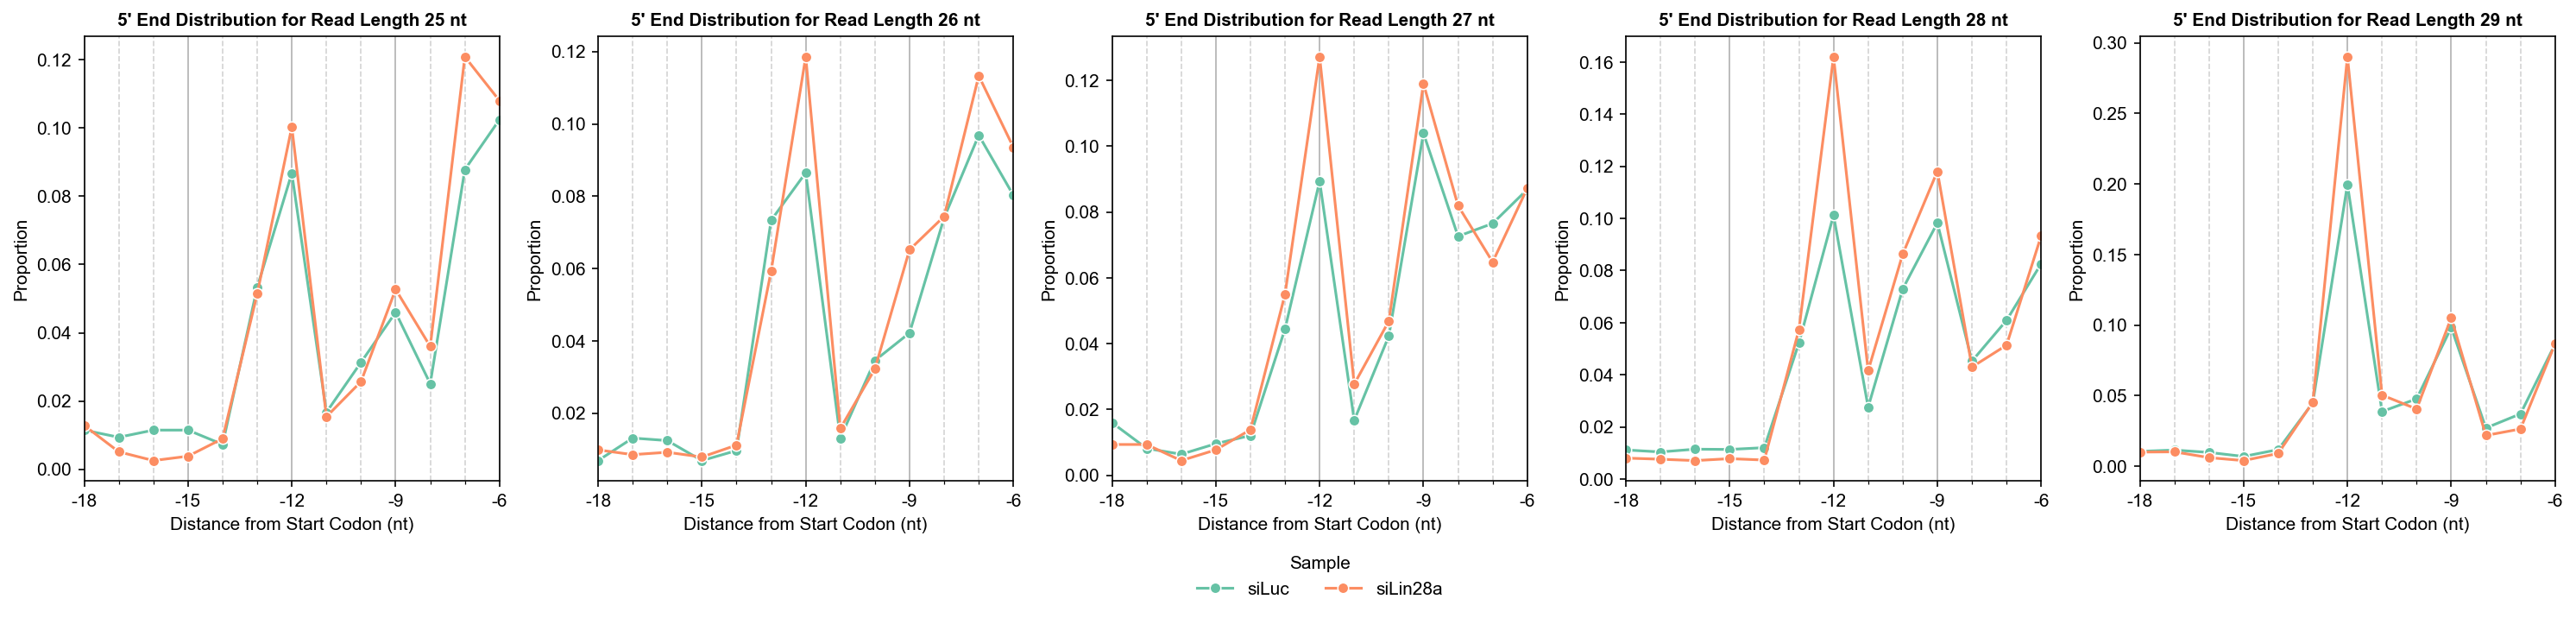

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(4 * 5, 5), dpi=150)
for i, length in enumerate(np.arange(25, 30)):
    row = siluc_5p_df.loc[length][list(np.arange(-18, -5))]
    sns.lineplot(x=row.index, y=row.values, ax=ax[i], marker='o', color='#66c2a5', label='siLuc' if i == 2 else None)
    row = silin28a_5p_df.loc[length][list(np.arange(-18, -5))]
    sns.lineplot(x=row.index, y=row.values, ax=ax[i], marker='o', color='#fc8d62', label='siLin28a' if i == 2 else None)

    ax[i].set_title(f'5\' End Distribution for Read Length {length} nt', fontsize=10, fontweight='bold')
    ax[i].set_xlabel('Distance from Start Codon (nt)', fontsize=10)
    ax[i].set_ylabel('Proportion', fontsize=10)
    ax[i].get_xaxis().set_major_locator(plt.MultipleLocator(3))
    ax[i].get_xaxis().set_minor_locator(plt.MultipleLocator(1))
    ax[i].grid(axis='x')
    ax[i].grid(axis='x', which='minor', color='lightgray', linestyle='--')
    ax[i].set_xlim(-18, -6)
    if i == 2:
        ax[i].legend(title='Sample', loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False)

plt.tight_layout()
plt.show()

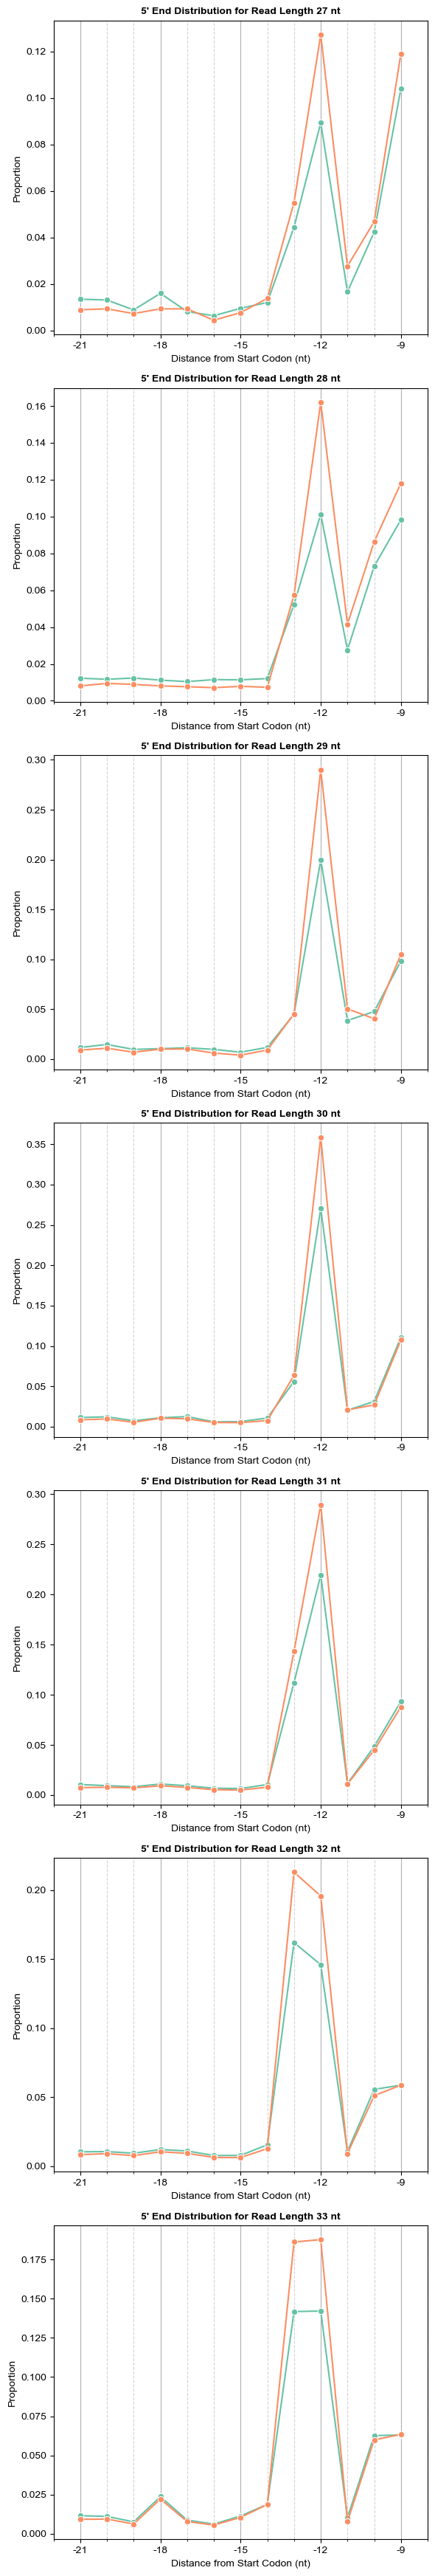

In [73]:
# Now determine P-site offset

cnt = 33 - 27 + 1
fig, ax = plt.subplots(nrows=cnt, ncols=1, figsize=(6, cnt * 5))
for i, length in enumerate(np.arange(27, 34)):
    row = siluc_5p_df.loc[length][list(np.arange(-21, -8))]
    sns.lineplot(x=row.index, y=row.values, ax=ax[i], marker='o', color='#66c2a5')
    row = silin28a_5p_df.loc[length][list(np.arange(-21, -8))]
    sns.lineplot(x=row.index, y=row.values, ax=ax[i], marker='o', color='#fc8d62')

    ax[i].set_title(f'5\' End Distribution for Read Length {length} nt', fontsize=10, fontweight='bold')
    ax[i].set_xlabel('Distance from Start Codon (nt)', fontsize=10)
    ax[i].set_ylabel('Proportion', fontsize=10)
    ax[i].get_xaxis().set_major_locator(plt.MultipleLocator(3))
    ax[i].get_xaxis().set_minor_locator(plt.MultipleLocator(1))
    ax[i].grid(axis='x')
    ax[i].grid(axis='x', which='minor', color='lightgray', linestyle='--')
    ax[i].set_xlim(-22, -8)

plt.tight_layout()
plt.show()

In [56]:
# P-site offsets of mESCs from (Ingolia et al., 2011)

# poffset = {
#     29: 12,
#     30: 12,
#     31: 13,
#     32: 13,
#     33: 13,
#     34: 14,
#     35: 14
# }

# My offsets. Exclude reads shorter than 27 nt, and longer than 33 nt.

poffset = {
    27: 12,
    28: 12,
    29: 12,
    30: 12,
    31: 12,
    32: 13,
    33: 13,
}

In [ ]:
# Maybe I can double-check offsets with A-site offsets from stop codon, but I will leave that for later

!(samtools view -H RPF-siLuc-filtered.bam; samtools view RPF-siLuc-filtered.bam | bioawk -c sam '{ if (length($seq) >= 27 && length($seq) <= 31) print $0; }') | samtools view -b -o  RPF-siLuc-filtered-27-31.bam
!(samtools view -H RPF-siLin28a-filtered.bam; samtools view RPF-siLin28a-filtered.bam | bioawk -c sam '{ if (length($seq) >= 27 && length($seq) <= 31) print $0; }') | samtools view -b -o  RPF-siLin28a-filtered-27-31.bam
!samtools index RPF-siLuc-filtered-27-31.bam
!samtools index RPF-siLin28a-filtered-27-31.bam

In [30]:
!grep $'\tCDS\t.*\t[+-]\t.*transcript_support_level "1"' ../binfo1-datapack1/gencode.gtf | sed -e 's/\t[^\t]*gene_id "\([^"]*\)".*transcript_id "\([^"]*\)".*$/\t\2\t\1/' > gencode-cds-with-genename.gtf

In [31]:
# -------------------------------- #
# -- Codes generated by Gemini --- #
# -------------------------------- #

# 2. 분석할 BAM 파일 경로
BAM_FILES = {
    'siLuc': 'RPF-siLuc-filtered27.bam',
    'siLin28a': 'RPF-siLin28a-filtered27.bam'
}

# 3. 주석(Annotation) 및 레퍼런스 유전체 파일 경로
GTF_FILE = 'gencode-cds-with-genename.gtf'

# pandas로 GTF 파일 읽기
gtf_df = pd.read_csv(
    GTF_FILE, sep='\t', comment='#', header=None,
    names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'transcript_id', 'gene_id']
)

# 전사체(transcript)를 기준으로 엑손 정보 그룹화
transcripts = {}
for transcript_id, group in tqdm(gtf_df.groupby('transcript_id'), desc="Processing Transcripts"):
    # 엑손들을 시작 위치 기준으로 정렬
    group = group.sort_values('start')

    transcripts[transcript_id] = {
        'gene_id': group['gene_id'].iloc[0],
        'chrom': group['chrom'].iloc[0],
        'strand': group['strand'].iloc[0],
        'exons': list(zip(group['start'], group['end']))
    }

print(f"총 {len(transcripts)}개의 전사체 정보 로드 완료.")

Processing Transcripts:   0%|          | 0/30846 [00:00<?, ?it/s]

총 30846개의 전사체 정보 로드 완료.


In [ ]:
def get_codon_counts_v2(bam_path, transcripts_info, genome_fasta, offset_map):
    """
    [V2] ORF를 정확히 고려하여 유전자별 P-site 코돈 카운트를 계산하는 함수
    """
    bamfile = pysam.AlignmentFile(bam_path, "rb")
    # 결과 저장 구조: {gene_id: {codon: count}}
    gene_codon_counts = defaultdict(lambda: defaultdict(int))
    # 프레임 벗어난 리드 카운트
    out_of_frame_counts = defaultdict(int)
    wrong_cds = 0
    # frame_df = pd.DataFrame(index=np.arange(27, 34), columns=['plus_0', 'plus_1', 'plus_2', 'minus_0', 'minus_1', 'minus_2']).fillna(0)
    # cnt = 0

    for transcript_id, t_info in tqdm(transcripts_info.items(), desc=f"Processing {bam_path}"):
        # cnt += 1
        # if cnt == 1000:
            # break
        # 1. 'CDS' 구간들로 실제 CDS 서열을 구성
        cds_seq = ""
        # t_info['exons']는 이제 CDS 구간들의 리스트임
        cds_segments = sorted(t_info['exons'], key=lambda x: x[0]) # 유전체 좌표 기준 정렬

        for cds_start, cds_end in cds_segments:
            cds_seq += genome_fasta[t_info['chrom']][cds_start - 1:cds_end].seq #  # 1-based, half-open 좌표이므로 cds_start - 1

        if t_info['strand'] == '-':
            tr_table = str.maketrans('ATCG', 'TAGC')
            cds_seq = cds_seq.upper().translate(tr_table)[::-1]

        # CDS 서열의 시작이 AUG가 아니거나 길이가 3의 배수가 아니면 건너뛰기 (품질 관리)
        if not cds_seq.startswith('ATG') or len(cds_seq) % 3 != 0:
            wrong_cds += 1
            continue

        # 2. 해당 전사체 영역의 리드들을 순회
        t_start = min(s for s, e in cds_segments)
        t_end = max(e for s, e in cds_segments)

        for read in bamfile.fetch(t_info['chrom'], t_start - 1, t_end):
            read_strand = '-' if read.is_reverse else '+'
            if read_strand != t_info['strand']:
                continue

            read_len = read.query_length
            if read_len not in offset_map:
                continue

            offset = offset_map[read_len]

            # 3. P-site의 '유전체' 좌표 계산
            # read.reference_start는 0-based, half-open 좌표임에 주의
            p_site_genomic = (read.reference_start + offset) if read_strand == '+' else (read.reference_end - 1 - offset)

            # 4. 유전체 좌표 -> 'CDS' 기준 상대 좌표로 변환
            p_site_cds = -1
            len_so_far = 0

            for cds_start, cds_end in cds_segments:
                if p_site_genomic >= cds_start - 1 and p_site_genomic < cds_end:
                    if t_info['strand'] == '+':
                        p_site_cds = len_so_far + (p_site_genomic - (cds_start - 1))
                    else:
                        p_site_cds = len_so_far + (cds_end - 1 - p_site_genomic)
                    break
                len_so_far += (cds_end - cds_start + 1)

            if p_site_cds == -1:
                continue

            # 5. 프레임 확인 및 코돈 카운트
            # P-site는 코돈의 첫번째 염기이므로, 0-based 좌표는 3의 배수여야 함
            # if read_strand == '+':
            #     frame_df.loc[read_len, f'plus_{p_site_cds % 3}'] += 1
            # elif read_strand == '-':
            #     frame_df.loc[read_len, f'minus_{p_site_cds % 3}'] += 1

            if p_site_cds % 3 == 0:
                if p_site_cds + 3 <= len(cds_seq):
                    codon = cds_seq[p_site_cds : p_site_cds + 3]
                    if 'N' not in codon:
                        gene_codon_counts[t_info['gene_id']][codon] += 1
            else:
                # 3의 배수가 아닌 경우 (out-of-frame)
                out_of_frame_counts[t_info['gene_id']] += 1

    bamfile.close()

    print(f"Total out-of-frame reads found: {sum(out_of_frame_counts.values())}, wrong CDS: {wrong_cds}")
    print(frame_df)
    result_df = pd.DataFrame.from_dict(gene_codon_counts, orient='index').fillna(0).astype(int)
    return result_df


In [55]:
# 레퍼런스 유전체 파일 열기
FASTA_FILE = '../binfo1-datapack1/mm39.fa'
genome = Fasta(FASTA_FILE, sequence_always_upper=True)

# 각 샘플에 대해 코돈 카운트 계산
results = {}
for name, bam_file in BAM_FILES.items():
    print(f"\n--- {name} 샘플 분석 시작 ---")
    results[name] = get_codon_counts_v2(bam_file, transcripts, genome, poffset)

genome.close()

print("\n--- 분석 완료 ---")

# siLuc 샘플 결과 확인
print("\nsiLuc 샘플 결과 (상위 5개 유전자):")
display(results['siLuc'].head())

# siLin28a 샘플 결과 확인
print("\nsiLin28a 샘플 결과 (상위 5개 유전자):")
display(results['siLin28a'].head())


--- siLuc 샘플 분석 시작 ---


/tmp/ipykernel_1970088/1814801781.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  frame_df = pd.DataFrame(index=np.arange(27, 34), columns=['plus_0', 'plus_1', 'plus_2', 'minus_0', 'minus_1', 'minus_2']).fillna(0)


Processing RPF-siLuc-filtered27.bam:   0%|          | 0/30846 [00:00<?, ?it/s]

Total out-of-frame reads found: 350939, wrong CDS: 5
    plus_0  plus_1  plus_2  minus_0  minus_1  minus_2
27    1248     693     896      736      667      672
28    5464    1597    3456     2770     2445     2763
29   15332    3092    6791     6855     5522     6337
30   46074    4160   14377    18623    13345    16738
31   62399    3889   41123    28470    22541    29344
32   42746    4095   53777    23989    23054    29191
33   20223    2889   30271    12987    12165    15049

--- siLin28a 샘플 분석 시작 ---


/tmp/ipykernel_1970088/1814801781.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  frame_df = pd.DataFrame(index=np.arange(27, 34), columns=['plus_0', 'plus_1', 'plus_2', 'minus_0', 'minus_1', 'minus_2']).fillna(0)


Processing RPF-siLin28a-filtered27.bam:   0%|          | 0/30846 [00:00<?, ?it/s]

Total out-of-frame reads found: 256194, wrong CDS: 5
    plus_0  plus_1  plus_2  minus_0  minus_1  minus_2
27     926     447     579      515      492      492
28    3922    1172    2143     1937     1586     1753
29   15193    2658    4312     6061     4386     5278
30   46056    3278   11720    16708    11550    14736
31   52468    2644   34110    22797    17906    23621
32   29690    2302   38692    16336    15351    19296
33   11799    1376   18850     7548     6903     8561

--- 분석 완료 ---

siLuc 샘플 결과 (상위 5개 유전자):


,GCC,GAG,GAT,CTA,AAT,TAC,CAG,GAA,TGC,CGA,...,AAC,CGT,CGC,GCG,GTC,CTT,CCG,ACG,GTA,ATA
ENSMUSG00000000001.5,1,5,8,3,5,11,5,8,3,1,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000028.16,4,8,6,3,0,2,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000048583.17,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000078.8,1,8,1,0,0,1,2,7,1,2,...,1,0,0,0,0,0,0,0,0,0
ENSMUSG00000000088.8,64,92,154,0,12,0,4,16,14,13,...,2,26,147,8,1,8,0,0,0,0



siLin28a 샘플 결과 (상위 5개 유전자):


,GTT,CTA,TAC,GAT,ATT,ATG,AAA,CAT,CGA,GTG,...,CTC,GCA,GCG,TGC,GGG,GTC,ACG,CCG,AGG,GTA
ENSMUSG00000000001.5,1,3,1,8,3,2,6,6,1,1,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000088.8,110,0,0,215,19,6,20,114,12,16,...,35,54,10,7,38,8,0,0,0,0
ENSMUSG00000000120.7,1,3,25,2,3,0,3,0,4,30,...,14,4,0,57,9,19,12,18,0,0
ENSMUSG00000020152.8,30,2,27,20,64,21,51,0,9,70,...,3,42,0,4,76,3,0,0,33,2
ENSMUSG00000000171.6,4,0,30,0,3,0,0,0,0,64,...,16,6,1,20,3,7,0,1,6,0


In [39]:
results['siLuc'].sum(axis=1).sum(), results['siLin28a'].sum(axis=1).sum()

(np.int64(5711345), np.int64(4495790))

In [ ]:
results['siLuc'].index.name = 'gene_id'
results['siLin28a'].index.name = 'gene_id'
results['siLuc'].to_csv('siLuc_codon_counts.csv')
results['siLin28a'].to_csv('siLin28a_codon_counts.csv')

# ------------------------------------ #
# --- End of Gemini generated code --- #
# ------------------------------------ #

In [3]:
# Checkpoint 2
siluc_codon_cnt = pd.read_csv('siLuc_codon_counts.csv', index_col=0)
silin28a_codon_cnt = pd.read_csv('siLin28a_codon_counts.csv', index_col=0)
siluc_codon_cnt.head(), silin28a_codon_cnt.head()

(                       AAT  CTT  TCT  CAT  TTT  CAG  CTA  CTG  AGA  GGC  ...  \
 gene_id                                                                  ...   
 ENSMUSG00000000001.5     4   22   31    8    7   10   16   16    8   12  ...   
 ENSMUSG00000000028.16    5   10   11   21    5   24   11   18   15   11  ...   
 ENSMUSG00000000078.8     1    0    1    5   18    4    2    1    7    1  ...   
 ENSMUSG00000000085.17    8    5   20    7   10    5    0    8    0    0  ...   
 ENSMUSG00000000088.8    14  126  314   42   44  250  172  290  124  124  ...   
 
                        CCG  AAA  TCA  TAC  GTC  AAG  ATA  ATC  CGG  GCG  
 gene_id                                                                  
 ENSMUSG00000000001.5     1    7    4   12   14    1    0    0    0    0  
 ENSMUSG00000000028.16    3    8    5    6    9   13    6    5    7    2  
 ENSMUSG00000000078.8     0    1    3    0    0    1    4    3    0    0  
 ENSMUSG00000000085.17    0   16   13    0   37    0   1

In [4]:
print(f"{len(siluc_codon_cnt[siluc_codon_cnt.sum(axis=1) == 0])} {len(silin28a_codon_cnt[silin28a_codon_cnt.sum(axis=1) == 0])} genes with no codon counts")

0 0 genes with no codon counts


In [5]:
siluc_codon_sum = siluc_codon_cnt.sum(axis=1)
silin28a_codon_sum = silin28a_codon_cnt.sum(axis=1)

In [9]:
siluc_codon_sum.name = 'siLuc_codon_sum'
silin28a_codon_sum.name = 'siLin28a_codon_sum'

In [11]:
gene_codon_sum = pd.concat([siluc_codon_sum, silin28a_codon_sum], axis=1)
gene_codon_sum.head()

,siLuc_codon_sum,siLin28a_codon_sum
gene_id,,
ENSMUSG00000000001.5,594.0,309.0
ENSMUSG00000000028.16,672.0,378.0
ENSMUSG00000000078.8,143.0,125.0
ENSMUSG00000000085.17,301.0,132.0
ENSMUSG00000000088.8,7614.0,8066.0


In [14]:
len(gene_codon_sum), len(gene_codon_sum[(gene_codon_sum['siLuc_codon_sum'] >= 50) & (gene_codon_sum['siLin28a_codon_sum'] >= 50)])

(16335, 9374)

(0.0, 40000.0)

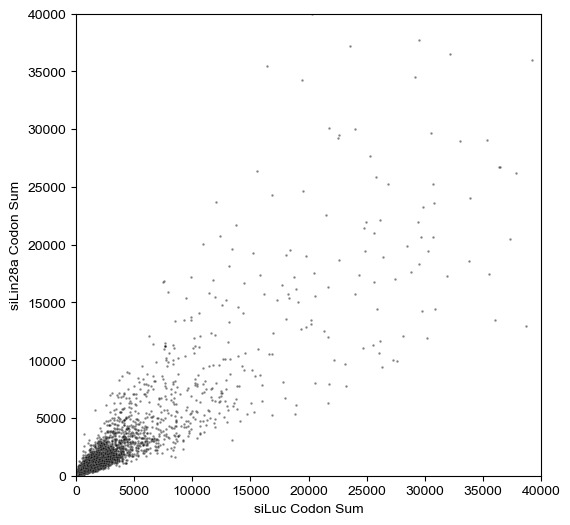

In [19]:
fig = plt.figure(figsize=(6, 6))
sns.scatterplot(data=gene_codon_sum, x='siLuc_codon_sum', y='siLin28a_codon_sum', color='black', s=3, alpha=0.5)
plt.xlabel('siLuc Codon Sum')
plt.ylabel('siLin28a Codon Sum')
plt.xlim(0, 40000)
plt.ylim(0, 40000)